<a href="https://colab.research.google.com/github/anhbui5302/nanoGPT/blob/master/examples/classifier_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier Finetune

In [138]:
# Install required libraries
!pip install -q -U transformers datasets accelerate peft bitsandbytes scikit-learn unsloth

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
from huggingface_hub import notebook_login

notebook_login()

In [140]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [141]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer
import numpy as np

# --- 1. Load your .jsonl data ---
# This part remains the same.
relevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_relevant_unique_500.jsonl'
irrelevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_irrelevant_unique_500.jsonl'

relevant_dataset = load_dataset('json', data_files=relevant_path, split='train')
irrelevant_dataset = load_dataset('json', data_files=irrelevant_path, split='train')

# --- 2. Combine and shuffle the data ---
# This part remains the same.
full_dataset = concatenate_datasets([relevant_dataset, irrelevant_dataset])
full_dataset = full_dataset.shuffle(seed=42)

# --- 3. Split the data into training and testing sets ---
# We split the raw data first.
final_datasets = full_dataset.train_test_split(test_size=0.1, seed=42)


# --- 4. Load the tokenizer ---
# The tokenizer is needed to apply the model's specific chat template.
# Note: This will be loaded again by Unsloth, which is fine. We need it here for formatting.
model_checkpoint = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# --- 5. Format the dataset using the official chat template ---
def format_chat_template(example):
    # The history and context are formatted as a single "user" turn.
    messages = [
        {
"role": "user", "content": (
            "Classify the following user message as either RELEVANT or IRRELEVANT. "
            "Only reply with the single word RELEVANT or the single word IRRELEVANT and nothing else.\n\n"
            "### MATH PROBLEM\n"
            f"Problem: {example['context']['problem']}\n"
            f"Solution: {example['context']['solution']}\n\n"
            "### CONVERSATION HISTORY\n" +
            "".join(f"{'AI Tutor' if msg['role'] == 'ai' else 'Student'}: {msg['content']}\n" for msg in example['history']) + "\n"
            "### USER MESSAGE\n"
            f"{example['user_message']}"
        )
        },
        # The assistant's label is the response it is being taught to generate.
        {
            "role": "assistant",
            "content": example['label']
        }
    ]
    # The tokenizer handles adding all the special tokens like '<start_of_turn>' and '<end_of_turn>'.
    # We create a new column called "text" which contains the fully formatted string.
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

# Apply the new formatting function to our datasets.
# Unsloth will handle the tokenization internally during training.
formatted_datasets = final_datasets.map(format_chat_template)

# --- 6. Verify the new format ---
# We print the output to see the result of the new formatting.
print("Training set size:", len(formatted_datasets['train']))
print("Test set size:", len(formatted_datasets['test']))
print("\nExample of a formatted prompt from the 'text' column:")
print(formatted_datasets['train'][0]['text'])

# The 'formatted_datasets' object is now ready to be passed directly into the Trainer.
# Make sure to use dataset_text_field="text" in your Trainer arguments.

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training set size: 900
Test set size: 100

Example of a formatted prompt from the 'text' column:
<bos><start_of_turn>user
Classify the following user message as either RELEVANT or IRRELEVANT. Only reply with the single word RELEVANT or the single word IRRELEVANT and nothing else.

### MATH PROBLEM
Problem: <div class="question" role=region aria-label="Question">
<h3 align="center">The Expanded Power Rule</h3>
<p align="center">`((ax)/(by))^n = (a^nx^n)/(b^ny^n)`</p>
<p>When you have a product or quotient raised to a power, you can apply the exponent to each factor.</p>
<p>Complete this expression.<br/>
  `(cw)^h=` <input type="text" size="20" name="qn28000" id="qn28000" value="" autocomplete="off" aria-label="Question 28 Part 1 of 3" class="text" /><span id=p28000></span>
</p>
<p>Simplify the following expression completely.<br/>
  `(3/v)^5 =` <input type="text" size="20" name="qn28001" id="qn28001" value="" autocomplete="off" aria-label="Question 28 Part 2 of 3" class="text" /><span i

Analyzing the training set:


Map (num_proc=4):   0%|          | 0/900 [00:00<?, ? examples/s]

--- Token Length Analysis ---
Total examples: 900
Min token length:    165
Max token length:    7038
Mean token length:   856.36
Median token length: 651.0

--- Percentiles ---
90th percentile: 1359
95th percentile: 1860
99th percentile: 5721
-----------------------------

This analysis helps you choose an optimal `max_seq_length`.
Your current max_seq_length is set to 512.
Examples longer than this will be truncated.
-----------------------------


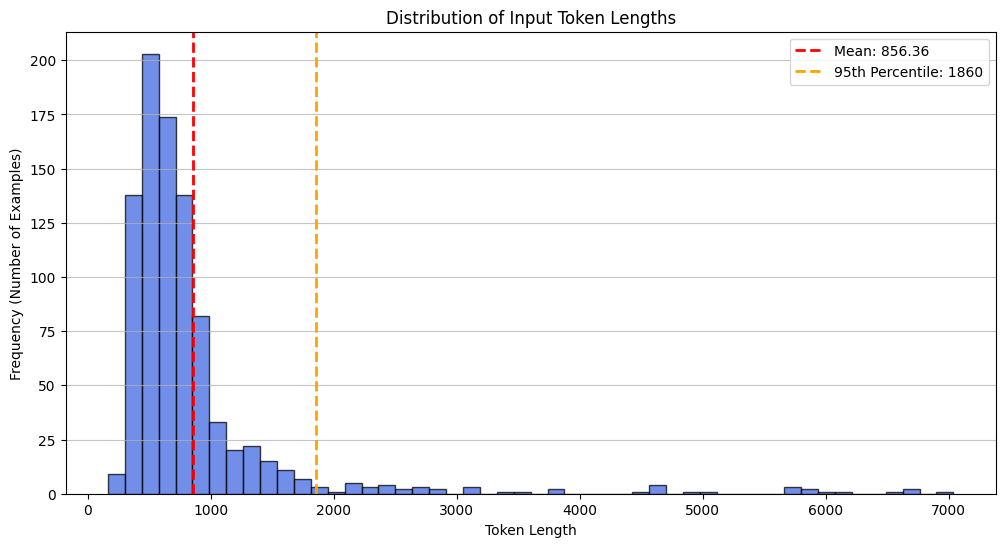


Analyzing the test set:


Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

--- Token Length Analysis ---
Total examples: 100
Min token length:    319
Max token length:    20318
Mean token length:   1045.40
Median token length: 658.0

--- Percentiles ---
90th percentile: 1398
95th percentile: 1768
99th percentile: 7417
-----------------------------

This analysis helps you choose an optimal `max_seq_length`.
Your current max_seq_length is set to 512.
Examples longer than this will be truncated.
-----------------------------


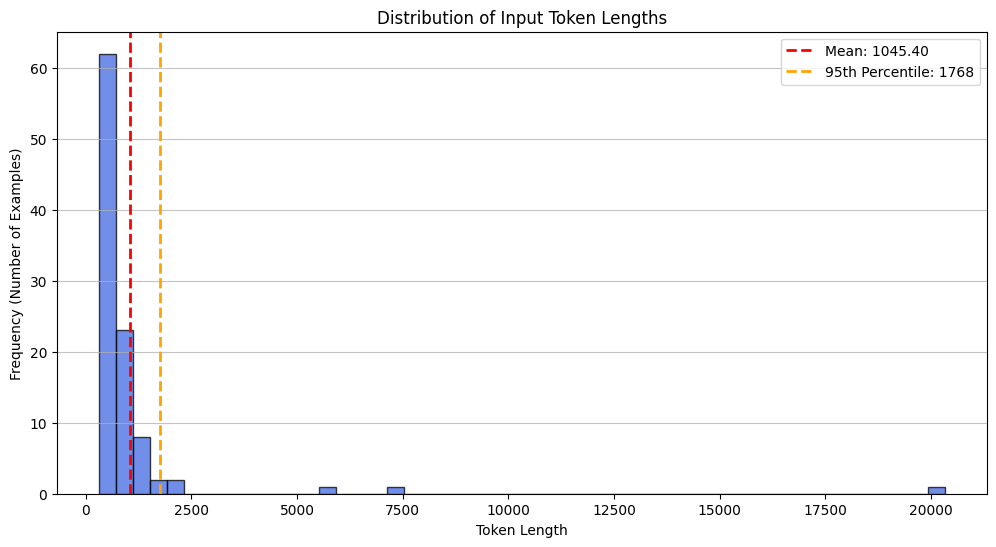

In [142]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_token_lengths(dataset, tokenizer, text_column="text"):
    """
    Calculates, prints statistics, and plots the distribution of token lengths
    for a given Hugging Face dataset.

    Args:
        dataset (datasets.Dataset): The dataset to analyze (e.g., formatted_datasets['train']).
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer for converting text to tokens.
        text_column (str): The name of the column in the dataset that contains the text.
    """
    # Use the efficient .map() function to tokenize and get the length of each input
    # This is much faster than iterating through the dataset in a loop.
    token_lengths = dataset.map(
        lambda example: {'length': len(tokenizer(example[text_column]).input_ids)},
        num_proc=4  # Use multiple processes to speed up the calculation
    )['length']

    token_lengths = np.array(token_lengths)

    # --- Calculate and Print Statistics ---
    print("--- Token Length Analysis ---")
    print(f"Total examples: {len(token_lengths)}")
    print(f"Min token length:    {np.min(token_lengths)}")
    print(f"Max token length:    {np.max(token_lengths)}")
    print(f"Mean token length:   {np.mean(token_lengths):.2f}")
    print(f"Median token length: {np.median(token_lengths)}")
    print("\n--- Percentiles ---")
    print(f"90th percentile: {np.percentile(token_lengths, 90):.0f}")
    print(f"95th percentile: {np.percentile(token_lengths, 95):.0f}")
    print(f"99th percentile: {np.percentile(token_lengths, 99):.0f}")
    print("-" * 29)
    print(f"\nThis analysis helps you choose an optimal `max_seq_length`.")
    print(f"Your current max_seq_length is set to 512.")
    print(f"Examples longer than this will be truncated.")
    print("-" * 29)


    # --- Plot the Histogram ---
    plt.figure(figsize=(12, 6))
    plt.hist(token_lengths, bins=50, alpha=0.75, color='royalblue', edgecolor='black')
    plt.axvline(np.mean(token_lengths), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(token_lengths):.2f}')
    plt.axvline(np.percentile(token_lengths, 95), color='orange', linestyle='dashed', linewidth=2, label=f'95th Percentile: {np.percentile(token_lengths, 95):.0f}')
    plt.title('Distribution of Input Token Lengths')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency (Number of Examples)')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# --- Example of how to call the function ---
# Make sure this is placed AFTER you have created your `formatted_datasets`
# and loaded your `tokenizer`.

print("Analyzing the training set:")
analyze_token_lengths(formatted_datasets['train'], tokenizer)

print("\nAnalyzing the test set:")
analyze_token_lengths(formatted_datasets['test'], tokenizer)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

# Using your preferred, explicit metric calculation
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    decoded_preds = [pred if pred else "__empty__" for pred in decoded_preds] # Handle empty predictions

    # Use the individual score functions as you requested
    precision = precision_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    recall = recall_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    f1 = f1_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    acc = accuracy_score(decoded_labels, decoded_preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [148]:
import torch
import unsloth
import numpy as np
from transformers import AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets
from trl import SFTTrainer


model, tokenizer = unsloth.FastLanguageModel.from_pretrained(
    model_name = model_checkpoint,
    max_seq_length = 1024,
    dtype = None, # Will auto-detect torch.bfloat16 if available
    load_in_4bit = True,
)

model = unsloth.FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    task_type = "CAUSAL_LM",
)
model.print_trainable_parameters()

model_name = model_checkpoint.split("/")[-1]
# Training Arguments
training_args = TrainingArguments(
    output_dir=f"{model_name}-classifier-finetune-3",
    num_train_epochs=5,
    per_device_train_batch_size = 1,  # We can likely go back to 2 now!
    gradient_accumulation_steps = 16, # Effective batch size is still 16
    gradient_checkpointing = True,   # Keep this for extra safety
    optim="adamw_8bit", # Unsloth works great with 8bit optimizers
    learning_rate=2e-4,
    logging_steps=25,
    fp16 = not torch.cuda.is_bf16_supported(), # Use bf16 if available, else fp16
    bf16 = torch.cuda.is_bf16_supported(),
    push_to_hub=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=formatted_datasets["train"],
    eval_dataset=formatted_datasets["test"],
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics,
    # preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Making `model.base_model.model.model` require gradients
trainable params: 2,981,888 || all params: 1,002,867,840 || trainable%: 0.2973
Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"]:   0%|          | 0/100 [00:00<?, ? examples/s]

In [149]:
# Start training!
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 900 | Num Epochs = 5 | Total steps = 285
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 2,981,888 of 1,002,867,840 (0.30% trained)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anhbui5302 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


InternalTorchDynamoError: ValueError: stoi


In [ ]:
eval_results = trainer.evaluate()


In [ ]:
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 1.036740779876709, 'eval_runtime': 18.4885, 'eval_samples_per_second': 5.409, 'eval_steps_per_second': 5.409}


# Eval

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!pip install -q -U transformers datasets accelerate peft bitsandbytes scikit-learn unsloth pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, LogitsProcessor, LogitsProcessorList

import unsloth

# --- 2. IMPORTANT: Fill in your details here! ---
# You must provide your Hugging Face username and the repository name.
huggingface_username = "andy013567" # <--- CHANGE THIS to your Hugging Face username
# This name is based on the output_dir from your training script.
model_repo_name = "gemma-3-1b-it-classifier-finetune-2"

# This creates the full model ID for the Hub
model_id = f"{huggingface_username}/{model_repo_name}"
print(f"Attempting to load model from: {model_id}")

/tmp/ipython-input-1620970219.py:8: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Attempting to load model from: andy013567/gemma-3-1b-it-classifier-finetune-2


In [4]:
# --- 3. Re-create the Test Dataset ---
# We need to reload and process the data to get the exact same test set.
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
relevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_relevant_unique_500.jsonl'
irrelevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_irrelevant_unique_500.jsonl'

relevant_dataset = load_dataset('json', data_files=relevant_path, split='train')
irrelevant_dataset = load_dataset('json', data_files=irrelevant_path, split='train')

full_dataset = concatenate_datasets([relevant_dataset, irrelevant_dataset])
# We MUST use the same seed to get the same train/test split
full_dataset = full_dataset.shuffle(seed=42)
final_datasets = full_dataset.train_test_split(test_size=0.1)

# We need a tokenizer to format the data correctly
# We can load the base model's tokenizer for this step
base_tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")

def format_chat_template_for_inference(example):
    messages = [
        {"role": "user", "content": (
            "Classify the following user message as either RELEVANT or IRRELEVANT. "
            "Only reply with the single word RELEVANT or the single word IRRELEVANT and nothing else.\n\n"
            "### MATH PROBLEM\n"
            f"Problem: {example['context']['problem']}\n"
            f"Solution: {example['context']['solution']}\n\n"
            "### CONVERSATION HISTORY\n" +
            "".join(f"{'AI Tutor' if msg['role'] == 'ai' else 'Student'}: {msg['content']}\n" for msg in example['history']) + "\n"
            "### USER MESSAGE\n"
            f"{example['user_message']}"
        )}
    ]
    # For inference, we want the tokenizer to add the generation prompt for the assistant
    return base_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# We are only creating prompts, not the full text with labels
test_dataset = final_datasets["test"]
inference_prompts = [format_chat_template_for_inference(ex) for ex in test_dataset]
ground_truth_labels = [ex['label'] for ex in test_dataset]



In [131]:
from peft import PeftModel
# --- 4. Load your fine-tuned model from the Hub ---
# Unsloth will download the model and merge the LoRA adapters automatically.
commit_hash = "cf6ca0cf2794a532fdf1068d342d6fa5171535d1"
model, tokenizer = unsloth.FastLanguageModel.from_pretrained(
    model_name = "google/gemma-3-4b-it",
    max_seq_length = 512,
    dtype = None,
    load_in_4bit = True,
)
tokenizer = tokenizer.tokenizer

# print(f"Loading adapter from: {model_id} at commit {commit_hash}")
# model = PeftModel.from_pretrained(
#     model,
#     model_id = model_id,
#     revision = commit_hash,
# )

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
<class 'transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration'>
<class 'transformers.models.gemma.tokenization_gemma_fast.GemmaTokenizerFast'>


In [145]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [133]:
# Add this cell to check your prompt lengths
import pandas as pd

token_lengths = [len(tokenizer.encode(prompt)) for prompt in inference_prompts]

print("Statistics for token lengths in the test set:")
print(pd.Series(token_lengths).describe())

# Find the longest prompt
max_len = max(token_lengths)
max_index = token_lengths.index(max_len)
print(f"\nThe longest prompt has {max_len} tokens.")
# print("\nContent of the longest prompt:")
# print(inference_prompts[max_index])

Statistics for token lengths in the test set:
count      100.000000
mean      1025.800000
std       2122.937521
min        318.000000
25%        497.750000
50%        599.500000
75%        854.750000
max      20313.000000
dtype: float64

The longest prompt has 20313 tokens.


In [134]:
gc.collect()
torch.cuda.empty_cache()

allowed_tokens = ["RELEVANT", "IRRELEVANT"]
allowed_token_ids = [tokenizer.encode(token, add_special_tokens=False)[0] for token in allowed_tokens]
print(f"Allowed token IDs: {allowed_token_ids}")

class AllowedTokensLogitsProcessor(LogitsProcessor):
    def __init__(self, allowed_token_ids):
        self.allowed_token_ids = allowed_token_ids

    def __call__(self, input_ids, scores):
        # Create a mask of all vocabulary tokens, setting them to -inf
        mask = torch.full_like(scores, -float("inf"))
        # Set the score of allowed tokens to 0, which means their original probability is kept
        mask[:, self.allowed_token_ids] = 0
        # Apply the mask to the scores
        return scores + mask

logits_processor = LogitsProcessorList([AllowedTokensLogitsProcessor(allowed_token_ids)])


print("\nGenerating constrained predictions on the test set using mini-batching...")

batch_size = 4  # A safe batch size for a T4 GPU. You can try 8 if this is fast.
model_predictions = []
tokenizer.padding_side = "left" # Set padding side for generation

# Loop through the prompts in chunks of `batch_size`
for i in tqdm(range(0, len(inference_prompts), batch_size)):
    batch_prompts = inference_prompts[i:i + batch_size]

    inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to("cuda")

    # The rest of the loop is the same
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=1,
        logits_processor=logits_processor,
        do_sample=False,
    )
    newly_generated_tokens = outputs[:, inputs.input_ids.shape[1]:]
    batch_predictions = tokenizer.batch_decode(newly_generated_tokens, skip_special_tokens=True)
    model_predictions.extend(batch_predictions)

Allowed token IDs: [1357, 3359]

Generating constrained predictions on the test set using mini-batching...


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


In [135]:
for pred in model_predictions:
    print(pred)

IR
RE
RE
IR
IR
RE
RE
RE
RE
IR
RE
RE
RE
IR
IR
RE
RE
RE
RE
RE
RE
RE
RE
RE
IR
RE
IR
RE
IR
RE
RE
IR
RE
RE
RE
RE
RE
IR
RE
RE
RE
IR
RE
RE
RE
RE
RE
RE
IR
IR
RE
IR
RE
RE
IR
RE
RE
RE
RE
IR
RE
RE
RE
RE
IR
RE
RE
RE
RE
RE
RE
RE
RE
IR
RE
RE
IR
RE
IR
RE
IR
RE
RE
RE
RE
RE
RE
IR
RE
RE
RE
RE
RE
RE
RE
IR
RE
RE
RE
IR


In [136]:
# --- 6. Handle Empty or Incomplete Predictions ---
valid_labels = {"RELEVANT", "IRRELEVANT"}
final_predictions = []
for pred_text, true_label in zip(model_predictions, ground_truth_labels):
    if pred_text == "RE":
        final_predictions.append("RELEVANT")
    elif pred_text == "IR":
        final_predictions.append("IRRELEVANT")
    else:
        # The model's output was invalid. We force it to be an incorrect prediction
        # by assigning it the opposite of the ground truth label.
        if true_label == "RELEVANT":
            final_predictions.append("IRRELEVANT")
        else:
            final_predictions.append("RELEVANT")

In [137]:
# --- 7. Calculate and Print the Metrics ---
print("\n--- Final Performance Metrics ---")

accuracy = accuracy_score(ground_truth_labels, final_predictions)
precision = precision_score(ground_truth_labels, final_predictions, pos_label='RELEVANT', zero_division=0)
recall = recall_score(ground_truth_labels, final_predictions, pos_label='RELEVANT', zero_division=0)
f1 = f1_score(ground_truth_labels, final_predictions, pos_label='RELEVANT', zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (for the 'RELEVANT' class)")
print(f"Recall:    {recall:.4f} (for the 'RELEVANT' class)")
print(f"F1-Score:  {f1:.4f} (for the 'RELEVANT' class)")


# --- 8. (Optional) Inspect some examples ---
print("\n--- Example Predictions ---")
df = pd.DataFrame({'Ground Truth': ground_truth_labels, 'Model Prediction': final_predictions})
print(df.head(10))

print("\n--- Incorrect Predictions ---")
incorrect_predictions = df[df['Ground Truth'] != df['Model Prediction']]
print(incorrect_predictions.head(10))


--- Final Performance Metrics ---
Accuracy:  0.5700
Precision: 0.5200 (for the 'RELEVANT' class)
Recall:    0.8478 (for the 'RELEVANT' class)
F1-Score:  0.6446 (for the 'RELEVANT' class)

--- Example Predictions ---
  Ground Truth Model Prediction
0   IRRELEVANT       IRRELEVANT
1   IRRELEVANT         RELEVANT
2   IRRELEVANT         RELEVANT
3     RELEVANT       IRRELEVANT
4   IRRELEVANT       IRRELEVANT
5   IRRELEVANT         RELEVANT
6   IRRELEVANT         RELEVANT
7     RELEVANT         RELEVANT
8     RELEVANT         RELEVANT
9   IRRELEVANT       IRRELEVANT

--- Incorrect Predictions ---
   Ground Truth Model Prediction
1    IRRELEVANT         RELEVANT
2    IRRELEVANT         RELEVANT
3      RELEVANT       IRRELEVANT
5    IRRELEVANT         RELEVANT
6    IRRELEVANT         RELEVANT
12   IRRELEVANT         RELEVANT
15   IRRELEVANT         RELEVANT
18   IRRELEVANT         RELEVANT
19   IRRELEVANT         RELEVANT
20   IRRELEVANT         RELEVANT
